# Understanding WSF
1. WSFevolution – outlining the settlement extent growth from 1985 to 2015 on a yearly basis. Pixel values range between 1985 and 2015 corresponding to the estimated year of settlement detection, whereas 0 is no data.

2. WSFevolution_RGB - the RGB version of the WSFevolution layer colored according to the “official” product palette (see the attached PNG legend).

3. WSFevolution_IDCscore – this actually requires a bit of explanation but is rather important. While generating the WSF evolution - as you might remember - we employed Landsat-based temporal statistics which proved generally robust if computed over at least 7 clear observations (i.e., no clouds / cloud shadows). If less than 7 clear observations are available for the target year, the time frame is enlarged backwards (at 1-year steps) as long as the condition is met. Of course, in the case of poor Landsat data availability the time frame might get rather large, which can lead to a lower quality of the product (and of course this does not depend on our methodology). Accordingly, to provide the user with a suitable and intuitive measure to account for this, we conceived the Input Data Consistency (IDC) Score ranging from 1 to 6 with: 1) very good; 2) good; 3) fair; 4)moderate; 5) low; 6) very low.

Here, you can see a screenshot of the IDC Score for the years 2015 and 2000, respectively. For instance, as you can notice the area in correspondence of Gabon is still critical in 2015, whereas the entire central Africa suffers from low data availability in the year 2000.
  
Furthermore, below I report an example for Mogadishu (Somalia). Specifically, in the lower right corner it is shown the 1985-2015 trend of the IDC Score for the pixel in correspondence of the light blue circle in the middle of the image. While the IDC is still “acceptable” back to 1997, previously it scores very low since basically no data are available. Accordingly, it shall be considered that – despite the pixel is then associated with the 1985 label – urbanization might even have occurred in reality between 1985 and 1997 (but we have no chance to “see” it).
 
In the provided archive, the IDC score is a 31-band file where band n.1 reports the IDC for the year 2015 and band n.31 that for 1985 (if you open it in arcMap or QGIS the name of each band is automatically loaded). In this way, it can be used in your analyses to explain some specific trends that might have not been properly captured.

4. WSF3D_AW3D30 – estimating the average building height per 100x100m cell (with vertical resolution set to 1m). Since data used for generating the ALOS DEM have been collected between 2006 and 2011, here I used the 2011 extent from the WSF evolution as reference settlement extent. This preliminary version of the product is quite promising and – from large qualitative comparison against VHR google imagery – seems rather accurate and reliable and can be an effective tool for generally characterizing the settlement morphology. However, some minor issues that should be taken into account include sometimes overestimation in the presence of high trees or gorges, as well as some overestimation in correspondence of dense buildings in areas with complex topography [e.g., (informal) settlements located on hills)]. Nevertheless, we are continuously working to further improve the layer and eventually can provide you with an updated version in case. Of course, here your feedback is definitely welcome. 

5. WSF3D_AW3D30_RGB - the RGB version of the WSF3D_AW3D30 layer colored according to the “official” product palette (see the attached PNG legend).

6. WSF3D_AW3D30_nScenes – reporting the number of original optical stereo images used in the generation of the ALOS DEM. Practically speaking, the higher this number, the higher the expected quality of the DEM. Where no data is available (due to cloud coverage), the layer has been filled in with SRTM DEM information, which is not feasible for estimating building height. Accordingly, I would recommend to disregard from your study the pixels where 0 scenes were available, and to be “cautious” where just one was used. From 2 upwards I generally expect at least a sufficient quality of the DEM.


In [3]:
import os, sys, json, logging, importlib

import rasterio
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

#Get reference to GOSTRocks
sys.path.append("../../../gostrocks/src")
sys.path.append('../../')

import GOSTRocks.rasterMisc as rMisc
import src.WSF.wsfdata as wsfdata

In [4]:
%matplotlib inline

In [5]:
inWSF_folder = "/home/public/Data/PROJECTS/LEI/DLR_V2"
outWSF_folder = "/home/wb411133/data/Global/WSF"

#Get a list of cities
allCities = {}
for root, dirs, files in os.walk(inWSF_folder):
    for f in files:
        if f[-4:] == ".tif":
            cityName = f.split("_")[0]
            if not cityName in allCities.keys():
                allCities[cityName] = [os.path.join(root, f)]
            else:
                allCities[cityName].append(os.path.join(root, f))

In [6]:
len(allCities.keys())

396

In [7]:
curCity = "Accra"
thresh = 3
wsfD = wsfdata.wsf_dataset(allCities[curCity])

../../src/WSF/wsfdata.py:121: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dataset == "normal":


In [11]:
wsfD.summarize_idc?

In [10]:
wsfD.correct_evolution_idc?

In [9]:
wsfD.analyze_idc?

In [12]:
wsfD.generate_evolution_plot?

In [ ]:
builtData = wsfD.generate_evolution_plot()
builtData['idcQuality'] = wsfD.summarize_idc(thresh=thresh)

outFolder = os.path.join(outWSF_folder, curCity)
if not os.path.exists(outFolder):
    os.makedirs(outFolder)
outQuality = os.path.join(outFolder, "quality_assessment_%s.tif" % thresh)
correctedEvolution = os.path.join(outFolder, "corrected_evolution_%s.tif" % thresh)

if not os.path.exists(outQuality):
    qualityRes = wsfD.analyze_idc(outFile=outQuality, badThreshold=thresh) 

correctedRes = wsfD.correct_evolution_idc(outfile=correctedEvolution, badThreshold=thresh)

basePlot = wsfD.generate_evolution_plot()
correctedPlot = wsfD.generate_evolution_plot(dataset=correctedRes)
basePlot['corrected'] = correctedPlot['cumBuilt']

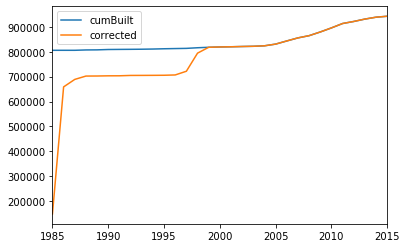

In [13]:
basePlot.drop('built', axis=1).plot()

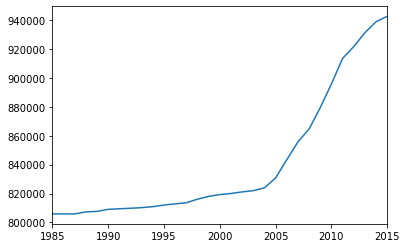

In [14]:
basePlot['cumBuilt'].plot()

In [16]:
#Loop through all the cities to process the results
importlib.reload(wsfdata)
allRes = []
for thresh in [2,3,4,5,6]:
    for curCity in ['Accra']allCities.keys():        
        if len(allCities[curCity]) > 1:
            try:
                wsfD = wsfdata.wsf_dataset(allCities[curCity])
                builtData = wsfD.generate_evolution_plot()
                builtData['idcQuality'] = wsfD.summarize_idc(thresh=thresh)
                allData = list(builtData[builtData.columns[1]].append(builtData[builtData.columns[2]]))
                allData.append(curCity)
                allRes.append(allData)
            except:
                print('Error processing: %s' % curCity)
            ''' UNCOMMENT THIS to GENERATE PLOTS
            #Plotting and correcting below
            outFolder = os.path.join(outWSF_folder, curCity)
            if not os.path.exists(outFolder):
                os.makedirs(outFolder)
            outQuality = os.path.join(outFolder, "quality_assessment_%s.tif" % thresh)
            correctedEvolution = os.path.join(outFolder, "corrected_evolution_%s.tif" % thresh)

            if not os.path.exists(outQuality):
                qualityRes = wsfD.analyze_idc(outFile=outQuality, badThreshold=thresh) 

            correctedRes = wsfD.correct_evolution_idc(outfile=correctedEvolution, badThreshold=thresh)

            basePlot = wsfD.generate_evolution_plot()
            correctedPlot = wsfD.generate_evolution_plot(dataset=correctedRes)
            basePlot['corrected'] = correctedPlot['cumBuilt']
            '''
    builtCols   = ["%s_%s" % (builtData.columns[1], x) for x in builtData.index]
    qualityCols = ["%s_%s" % (builtData.columns[2], x) for x in builtData.index]
    columns = (builtCols + qualityCols)
    columns.append("CITY")

    finalRes = pd.DataFrame(allRes)
    finalRes.columns = columns
    finalRes.to_csv(os.path.join(outWSF_folder, "compiled_WSF_quality_%s_v2.csv" % thresh))

Error processing: Jaipur
Error processing: Jaipur
Error processing: Jaipur
Error processing: Jaipur
Error processing: Jaipur


In [20]:
outWSF_folder

'/home/wb411133/data/Global/WSF'

# Debugging Below

In [ ]:
importlib.reload(wsfdata)
wsfD = wsfdata.wsf_dataset(allCities[curCity])
evolution = rasterio.open(wsfD.evolution).read()
idc = rasterio.open(wsfD.evolution_idc).read()

In [ ]:
allCities.keys()

In [ ]:
totalCells = (evolution[0,:,:] > 0).sum()
allRes = []
for idx in range(0, evolution_masked.shape[0]):
    allRes.append((evolution_masked[idx,:,:] < thresh).sum() / totalCells)

In [ ]:
allCities['Houston'][3]

In [ ]:
from rasterio.features import shapes
from shapely.geometry import shape
import geojson, json
### Testing new WSF work using rasterio
inFile = allCities['Houston'][3]
inD = rasterio.open(inFile)
x = inD.read()

In [ ]:
# generate two datasets based on new and old built area
oldDate = 2000
newDate = 2015

oldD = (x < oldDate) * (x > 0)
newD = (x > oldDate) * (x < newDate)

newBuilt_shapes = shapes(newD.astype(np.int16), transform = inD.transform)
allGeoms = [shape(geojson.loads(json.dumps(xx[0]))) for xx in newBuilt_shapes if xx[1] != 0]
curDF = gpd.GeoDataFrame(pd.DataFrame({"Date":[newDate] * len(allGeoms)}), geometry=allGeoms)    